In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your cleaned augmented dataset CSV.
# You can use cleaned_dataset.csv if you want only original images, or cleaned_augmented_dataset.csv if you want both.
df = pd.read_csv("cleaned_augmented_dataset.csv")

# Optionally, if you want only original images for testing, filter out rows containing "_aug_"
# Uncomment the following line if needed:
# df = df[~df["Image"].str.contains("_aug_")].copy()

# Convert the Age column to numeric (if not already)
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df = df.dropna(subset=["Age"])

# Split the data: 80% train/validation, 20% test.
# We only need the test set for evaluation.
_, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Save the test CSV for multimodal evaluation
test_csv_path = "test_multimodel.csv"
df_test.to_csv(test_csv_path, index=False)
print(f"✅ Test multimodal CSV saved as {test_csv_path}")


✅ Test multimodal CSV saved as test_multimodel.csv


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pickle

# Load test dataset
test_df = pd.read_csv("test_multimodel.csv")

# Load tokenizer
with open("text_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Ensure 'Historical Notes' exists in the CSV
if "Historical Notes" not in test_df.columns:
    test_df["Historical Notes"] = ""

# Process text input
max_len = 100  # Should match training config
test_texts = test_df["Historical Notes"].fillna("").values
test_sequences = tokenizer.texts_to_sequences(test_texts)
X_text = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len, padding="post")

# Load and preprocess an image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return np.zeros((224, 224, 3), dtype=np.float32)  # Dummy image for missing files
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    return img.astype(np.float32) / 255.0

# Load images
image_paths = test_df["Image"].values
X_images = np.array([preprocess_image(img) for img in image_paths])

# Load trained model
model = tf.keras.models.load_model("final_multimodal_model.keras")

# Make predictions
predictions = model.predict({"image_input": X_images, "text_input": X_text})

# Save predictions
test_df["Predicted Age"] = predictions.flatten()
test_df.to_csv("test_predictions.csv", index=False)

print("✅ Predictions saved in test_predictions.csv")


29/29 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step 
✅ Predictions saved in test_predictions.csv


29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step 
📊 Prediction Mean Absolute Error (MAE): 94.12 years
Actual: 200.0, Predicted: 623.287353515625, Image: artifact_dataset/augmented_images\327276_aug1.jpg
Actual: 200.0, Predicted: 637.8414306640625, Image: artifact_dataset/augmented_images\327276_aug2.jpg
Actual: 50.0, Predicted: 523.4410400390625, Image: artifact_dataset/augmented_images\324025_aug5.jpg
Actual: 466.5, Predicted: 952.3773193359375, Image: artifact_dataset/augmented_images\44833_aug2.jpg
Actual: 50.0, Predicted: 631.807373046875, Image: artifact_dataset/augmented_images\324025_aug2.jpg
Actual: 649.5, Predicted: 1245.2269287109375, Image: artifact_dataset/augmented_images\466048_aug4.jpg
Actual: 312.5, Predicted: 930.9273681640625, Image: artifact_dataset/augmented_images\468759_aug1.jpg
Actual: 649.5, Predicted: 1298.760009765625, Image: artifact_dataset/augmented_images\466048_aug1.jpg
Actual: 1218.5, Predicted: 515.5546875, Image: artifact_dataset/augmented_images\454763_aug5.jpg

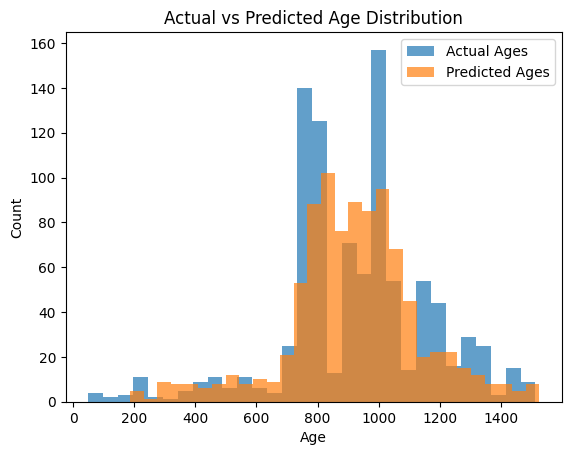

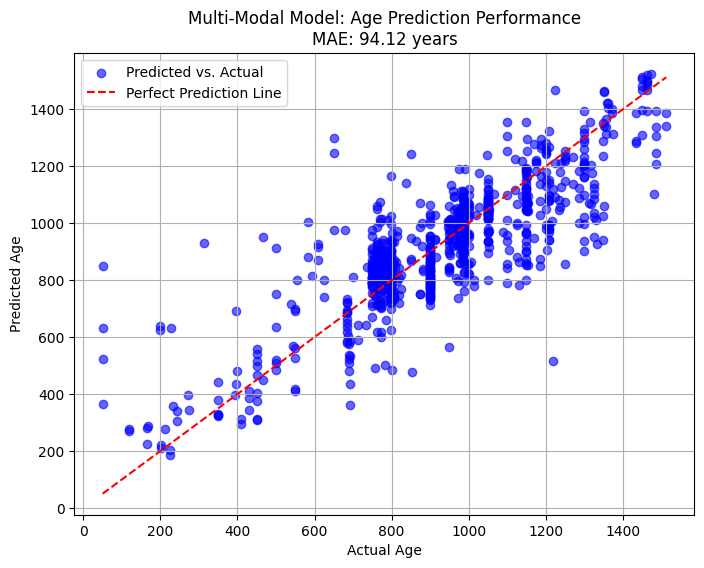

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import cv2
from sklearn.metrics import mean_absolute_error

# === Load Trained Model ===
model = tf.keras.models.load_model("final_multimodal_model.keras")

# === Load Test Data ===
test_df = pd.read_csv("test_multimodel.csv")

# === Load Tokenizer for Text Processing ===
with open("text_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# === Process Text Data ===
max_len = 100  # Same as used during training
test_text = test_df["Historical Notes"].fillna("").values
test_sequences = tokenizer.texts_to_sequences(test_text)
X_text = pad_sequences(test_sequences, maxlen=max_len, padding="post")

# === Process Image Data ===
def load_and_preprocess_image(path):
    img = cv2.imread(path)
    if img is None:
        img = np.zeros((224, 224, 3), dtype=np.uint8)  # Handle missing images
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

X_images = np.array([load_and_preprocess_image(img_path) for img_path in test_df["Image"]])

# === Get Actual Ages ===
y_actual = test_df["Age"].values

# === Run Model Predictions ===
y_pred = model.predict({"image_input": X_images, "text_input": X_text}).flatten()

# === Compute Mean Absolute Error (MAE) ===
mae = mean_absolute_error(y_actual, y_pred)
print(f"📊 Prediction Mean Absolute Error (MAE): {mae:.2f} years")
errors = abs(y_actual - y_pred)
worst_indices = np.argsort(errors)[-10:]  # Top 10 worst cases
for i in worst_indices:
    print(f"Actual: {y_actual[i]}, Predicted: {y_pred[i]}, Image: {test_df['Image'][i]}")
import matplotlib.pyplot as plt

plt.hist(y_actual, bins=30, alpha=0.7, label="Actual Ages")
plt.hist(y_pred, bins=30, alpha=0.7, label="Predicted Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.title("Actual vs Predicted Age Distribution")
plt.show()

# === Plot Predictions vs Actual ===
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred, alpha=0.6, color='blue', label="Predicted vs. Actual")
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle="--", label="Perfect Prediction Line")
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title(f"Multi-Modal Model: Age Prediction Performance\nMAE: {mae:.2f} years")
plt.legend()
plt.grid(True)
plt.show()
